In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

directories = ['Sounds/ambulance', 'Sounds/firetruck']

X = []
y = []

# Define the duration of the audio clip that we want to analyze (in seconds)
clip_duration = 3  # seconds

# Process each file in each directory
for label, directory in enumerate(directories):
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            # Load the .wav file
            file_path = os.path.join(directory, filename)
            audio, sr = librosa.load(file_path, sr=None, duration=clip_duration)

            # Calculate the Mel-frequency cepstral coefficients (MFCCs) with reduced number
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfccs_processed = np.mean(mfccs.T, axis=0)

            # Append features and label
            X.append(mfccs_processed)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

In [3]:
# Evaluate the predictions
print("confusion matrix")
print(confusion_matrix(y_test, y_pred))
print("classification report")
print(classification_report(y_test, y_pred))

confusion matrix
[[41  3]
 [ 6 30]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        44
           1       0.91      0.83      0.87        36

    accuracy                           0.89        80
   macro avg       0.89      0.88      0.89        80
weighted avg       0.89      0.89      0.89        80



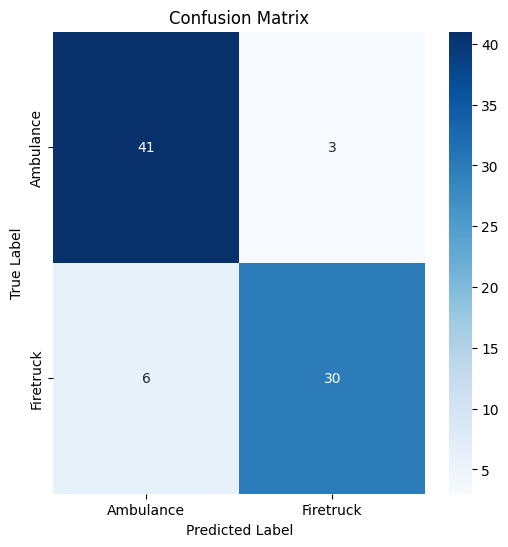

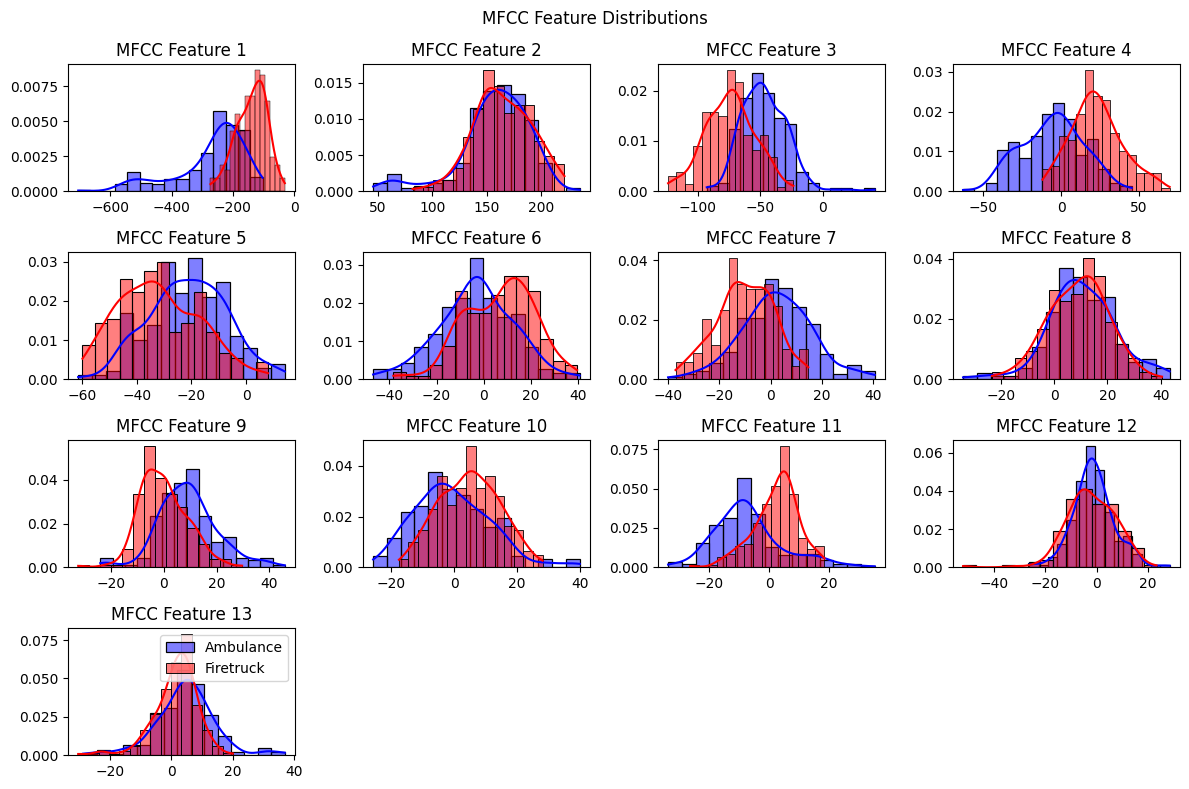

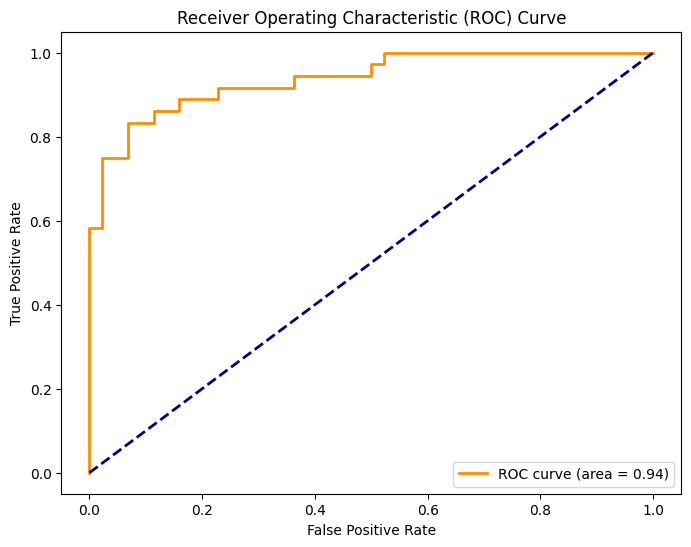

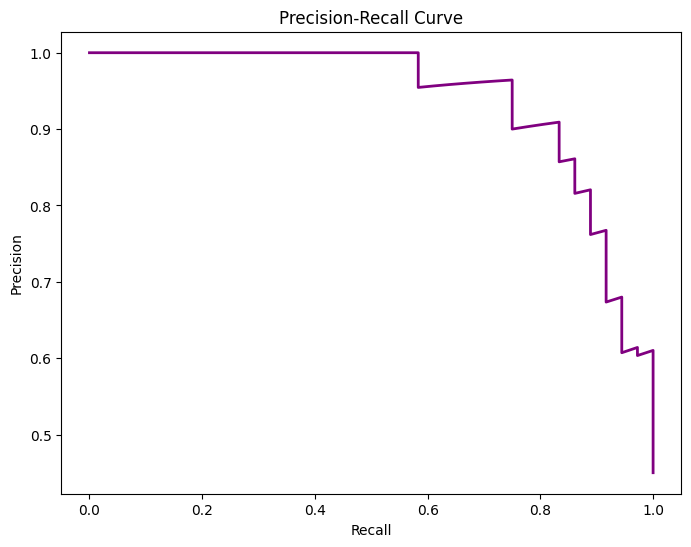

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Confusion Matrix Heatmap
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ambulance', 'Firetruck'], yticklabels=['Ambulance', 'Firetruck'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# MFCC Feature Distribution for Each Class
def plot_mfcc_distribution(X, y):
    plt.figure(figsize=(12, 8))
    for i in range(13): 
        plt.subplot(4, 4, i + 1)
        sns.histplot(X[y == 0][:, i], color='blue', label='Ambulance', kde=True, stat="density", bins=15)
        sns.histplot(X[y == 1][:, i], color='red', label='Firetruck', kde=True, stat="density", bins=15)
        plt.title(f'MFCC Feature {i+1}')
        plt.xlabel('')
        plt.ylabel('')
    plt.suptitle('MFCC Feature Distributions')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ROC Curve
def plot_roc_curve(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_proba):
    precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

plot_confusion_matrix(y_test, y_pred)
plot_mfcc_distribution(X, y)

# If probabilities are available 
if hasattr(clf, "predict_proba"):
    y_proba = clf.predict_proba(X_test)
    plot_roc_curve(y_test, y_proba)
    plot_precision_recall_curve(y_test, y_proba)

In [9]:
import numpy as np

def add_noise(audio, snr_db):
    """
    Adds white noise to the audio signal to achieve a desired SNR level
    """
    rms_signal = np.sqrt(np.mean(audio**2))
    
    snr_linear = 10 ** (snr_db / 10)
    
    rms_noise = rms_signal / np.sqrt(snr_linear)
    
    noise = np.random.normal(0, rms_noise, audio.shape)
    
    noisy_audio = audio + noise
    return noisy_audio

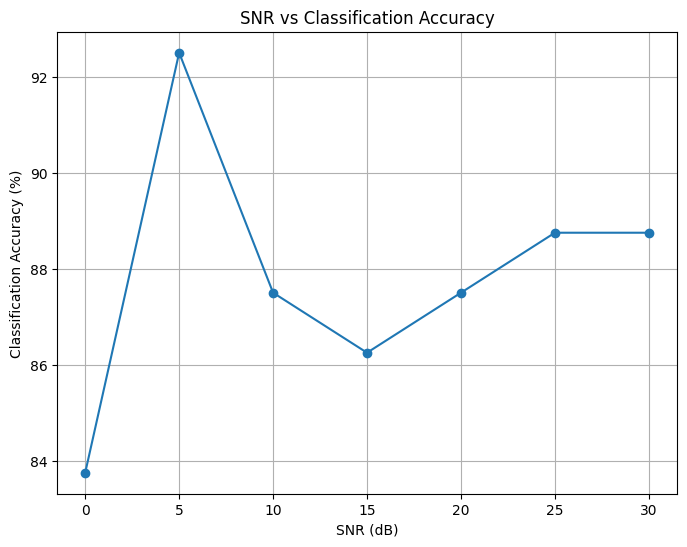

In [11]:
from sklearn.metrics import accuracy_score
snr_values = np.arange(0, 31, 5)  

accuracy_scores = []

for snr in snr_values:
    X_test_noisy = []

    for sample in X_test:
        noisy_sample = add_noise(sample, snr) 
        X_test_noisy.append(noisy_sample)

    X_test_noisy = np.array(X_test_noisy)

    y_pred_noisy = clf.predict(X_test_noisy)

    accuracy = accuracy_score(y_test, y_pred_noisy)
    accuracy_scores.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(snr_values, np.array(accuracy_scores) * 100, marker='o')  
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy (%)')
plt.title('SNR vs Classification Accuracy')
plt.grid()
plt.show()